In [1]:
import numpy as np
import ase.io
import tqdm
from nice.blocks import *
from nice.utilities import *
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import Ridge

In [2]:
HARTREE_TO_EV = 27.211386245988
FORCE_FACTOR = 51.42208619083232
train_subset = "0:1500"  #input for ase.io.read command
test_subset = "1500:2000"  #input to ase.io.read command
environments_for_fitting = 1000  #number of environments to fit nice transfomers
GRID = [150, 200, 350, 500, 750, 1000, 1500, 2000, 2500]  #for learning curve

#HYPERS for librascal spherical expansion coefficients
LAMBDA_MAX = 5
HYPERS = {
    'interaction_cutoff': 6.3,
    'max_radial': 5,
    'max_angular': LAMBDA_MAX,
    'gaussian_sigma_type': 'Constant',
    'gaussian_sigma_constant': 0.05,
    'cutoff_smooth_width': 0.3,
    'radial_basis': 'GTO'
}
MAGIC_NUMBER = 10000
BATCH_SIZE = 500

train_structures = ase.io.read('methane.extxyz', index=train_subset)

test_structures = ase.io.read('methane.extxyz', index=test_subset)

all_species = get_all_species(train_structures + test_structures)

train_energies = [structure.info['energy'] for structure in train_structures]
train_energies = np.array(train_energies) * HARTREE_TO_EV
e_mean = np.mean(train_energies)
train_energies -= e_mean

test_energies = [structure.info['energy'] for structure in test_structures]
test_energies = np.array(test_energies) * HARTREE_TO_EV
test_energies -= e_mean
print(np.min(train_energies), np.max(train_energies))

-7.519471700884196 26.095904038212893


# NICE cython

In [3]:
#our model:
def get_nice():
    return StandardSequence([
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
        StandardBlock(ThresholdExpansioner(),
                      CovariantsPurifierBoth(regressor = Ridge(alpha = 1e-5)),
                      IndividualLambdaPCAsBoth(n_components=20),
                      None,
                      None,
                      None),
       
    ],
                           )

In [4]:
train_coefficients = get_spherical_expansion(train_structures, HYPERS,
                                             all_species)

test_coefficients = get_spherical_expansion(test_structures, HYPERS,
                                            all_species)

for key in train_coefficients.keys():
    train_coefficients[key] *= MAGIC_NUMBER
    test_coefficients[key] *= MAGIC_NUMBER



100%|██████████| 2/2 [00:00<00:00, 900.16it/s]


In [5]:
nice = get_nice()
np.random.seed(0)
nice.fit(train_coefficients[6][:environments_for_fitting])

In [6]:
def get_features(nice, coefs):
    features = {}
    for i in range(0, coefs.shape[0], BATCH_SIZE):
        now = nice.transform(coefs[i : i + BATCH_SIZE], return_only_invariants = True)
        for key in now.keys():
            if key in features.keys():
                features[key].append(now[key])
            else:
                features[key] = [now[key]]
    for key in features.keys():
        features[key] = np.concatenate(features[key], axis = 0)
    return features

In [7]:
train_features = get_features(nice, train_coefficients[6])
test_features = get_features(nice, test_coefficients[6])
for key in train_features.keys():
    print(train_features[key].shape)

(1500, 10)
(1500, 20)
(1500, 20)
(1500, 20)


In [8]:
for key in train_features.keys():
    print(key, train_features[key].shape)
#print(train_features[1][0:10])
#print(train_features[2][0:10])

1 (1500, 10)
2 (1500, 20)
3 (1500, 20)
4 (1500, 20)


In [9]:
def get_rmse(first, second):
    return np.sqrt(np.mean((first - second)**2))


def get_standard_deviation(values):
    return np.sqrt(np.mean((values - np.mean(values))**2))


def get_relative_performance(predictions, values):
    return get_rmse(predictions, values) / get_standard_deviation(values)


def estimate_performance(regressor, data_train, data_test, targets_train,
                         targets_test):
    regressor.fit(data_train, targets_train)
    return get_relative_performance(regressor.predict(data_test), targets_test)

def get_lr(regressor, data_train, data_test, targets_train,
           targets_test):
    result = []
    for el in GRID:
        result.append(estimate_performance(regressor, data_train[:el], data_test,
                                           targets_train[:el], targets_test))
    return result

(1500, 10)
(1500, 30)
(1500, 50)
(1500, 70)


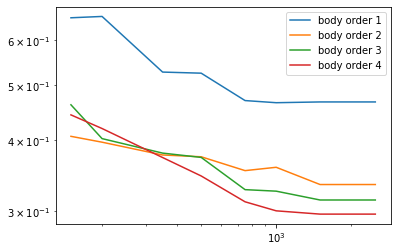

In [10]:
for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# NICE pytorch

In [11]:
from pytorch_prototype.nice_blocks import *
from pytorch_prototype.utilities import *

In [12]:
def split(coefficients):
    lambd_max = max(coefficients.keys())
    even, odd = {}, {}
    for lambd in range(lambd_max + 1):
        if lambd % 2 == 0:
            even[str(lambd)] = coefficients[lambd]
        else:
            odd[str(lambd)] = coefficients[lambd]
    return even, odd


train_coefficients_all = get_coefs(train_structures, HYPERS, all_species)
test_coefficients_all = get_coefs(test_structures, HYPERS, all_species)
for key in train_coefficients_all.keys():
    train_coefficients_all[key] *= MAGIC_NUMBER
    test_coefficients_all[key] *= MAGIC_NUMBER
    
central = get_central_species(train_structures)
mask = central == 6
train_coefficients = {}
for key in train_coefficients_all.keys():
    train_coefficients[key] = train_coefficients_all[key][mask]
    

central = get_central_species(test_structures)
mask = central == 6
test_coefficients = {}
for key in test_coefficients_all.keys():
    test_coefficients[key] = test_coefficients_all[key][mask]
                                                
    
train_even, train_odd = split(train_coefficients)
test_even, test_odd = split(test_coefficients)


for key in train_even.keys():
    print(key, train_even[key].shape)
for key in test_even.keys():
    print(key, test_even[key].shape)

0 torch.Size([1500, 10, 1])
2 torch.Size([1500, 10, 5])
4 torch.Size([1500, 10, 9])
0 torch.Size([500, 10, 1])
2 torch.Size([500, 10, 5])
4 torch.Size([500, 10, 9])


In [13]:
blocks = [BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(20)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(20)),
         BodyOrderIteration(Expansioner(LAMBDA_MAX), 
                           Purifier(regressor = Ridge(alpha = 1e-5)),
                           Compressor(20))]
nice = NICE(blocks)
for_fit_even, for_fit_odd = {}, {}
for key in train_even.keys():
    for_fit_even[key] = train_even[key][:environments_for_fitting]
    print(for_fit_even[key].shape)
for key in test_odd.keys():
    for_fit_odd[key] = train_odd[key][:environments_for_fitting]
    print(for_fit_odd[key].shape)
np.random.seed(0)   
nice.fit(for_fit_even, for_fit_odd)

torch.Size([1000, 10, 1])
torch.Size([1000, 10, 5])
torch.Size([1000, 10, 9])
torch.Size([1000, 10, 3])
torch.Size([1000, 10, 7])
torch.Size([1000, 10, 11])


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.83388e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.21793e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.64796e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.15659e-08): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.83388e-08): result may not be accurate.
  return linalg.so

In [14]:
def convert(features):
    result = {}
    for i in range(len(features)):
        #print(features[i].keys())
        result[i + 1] = features[i]['0'].squeeze().data.cpu().numpy()
    return result

In [15]:
train_features, _ = nice(train_even, train_odd)
train_features = convert(train_features)

test_features, _ = nice(test_even, test_odd)
test_features = convert(test_features)

In [16]:
for key in train_features.keys():
    print(key, train_features[key].shape)

1 (1500, 10)
2 (1500, 20)
3 (1500, 20)
4 (1500, 20)


In [17]:
'''print(train_features[1][0:10])
print(train_features[2][0:10])'''

'print(train_features[1][0:10])\nprint(train_features[2][0:10])'

(1500, 10)
(1500, 30)
(1500, 50)
(1500, 70)


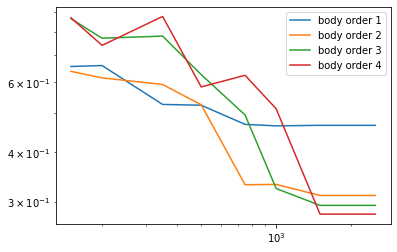

In [18]:
for index in range(1, 5):
    train = [train_features[i] for i in range(1, index + 1)]
    test = [test_features[i] for i in range(1, index + 1)]
    train = np.concatenate(train, axis = 1)
    test = np.concatenate(test, axis = 1)
    print(train.shape)
    lr = get_lr(BayesianRidge(), train, test, train_energies, test_energies)
    plt.plot(GRID, lr, label = "body order {}".format(index))
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

(1500, 70)
(500, 70)


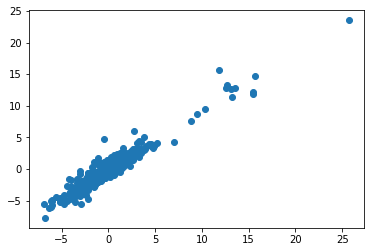

(70,)


In [19]:
print(train.shape)
rgr = BayesianRidge(fit_intercept = False)
rgr.fit(train, train_energies)
predictions = rgr.predict(test)
print(test.shape)
plt.plot(test_energies, predictions, 'o')
plt.show()
best_weight = rgr.coef_
print(best_weight.shape)

In [20]:
class Dummy(torch.nn.Module):
    def __init__(self):
        super(Dummy, self).__init__()
    def forward(self, X):
        return {"energy" : torch.zeros(X[0].shape[0], 1)}
    
class NICE_predictions(torch.nn.Module):
    def __init__(self, nice, in_shape, out_shape):
        super(NICE_predictions, self).__init__()
        self.nice = nice
        self.linear = nn.Linear(in_shape, out_shape, bias = False)
        
    def forward(self, X):
        even, odd = split(X)
        features, _ = nice(even, odd)
        conc = []
        for i in range(len(features)):
            conc.append(features[i]['0'].squeeze())
        conc = torch.cat(conc, dim = 1)
        print(conc[0,0:20])
        print(conc.shape)
        return {"energy": self.linear(conc)}

In [21]:
model = NICE_predictions(nice, 70, 1)
print(model.linear.weight.shape)
with torch.no_grad():
    best_weight = torch.from_numpy(best_weight)[None, :]
    model.linear.weight.copy_(best_weight)
print(model.linear.weight[0, 0:20])
result = model(test_coefficients)
print(result["energy"].shape)

torch.Size([1, 70])
tensor([-2.2599e-01, -2.1038e+00,  1.9089e+01,  1.0403e+02,  2.5750e+03,
         8.1190e+00,  1.1060e-03, -1.2825e-04,  4.1874e-03,  1.9922e-06,
         1.7065e+01,  1.3406e+00, -1.6452e+00, -8.1531e+00,  5.4760e+00,
        -5.8698e+00, -8.8088e+00,  1.3269e+01, -1.1095e+01,  2.6339e+00],
       grad_fn=<SliceBackward>)
tensor([ 9.0668e-01,  1.9149e-01,  3.9534e-02, -7.4733e-03,  9.4849e-05,
        -5.1738e-06,  3.3760e-08, -4.6566e-10,  5.5879e-09,  3.7253e-09,
        -6.5732e-02,  5.2424e-02, -7.6401e-03, -1.5376e-02, -7.9785e-03,
        -2.9125e-02,  4.1247e-03,  1.0100e-02,  4.1273e-02,  4.7320e-02],
       grad_fn=<SliceBackward>)
torch.Size([500, 70])
torch.Size([500, 1])


In [22]:
models = {'1' : Dummy(), '6' : model}
atomistic = Atomistic(models)

In [23]:
print(test_coefficients_all[0].shape)

torch.Size([2500, 10, 1])


In [24]:
result = atomistic(test_coefficients_all, central_species = get_central_species(test_structures),
                   structural_indices = get_structural_indices(test_structures))
test_predictions = result['energy'].data.cpu().numpy().squeeze()

tensor([ 9.0668e-01,  1.9149e-01,  3.9534e-02, -7.4733e-03,  9.4849e-05,
        -5.1738e-06,  3.3760e-08, -4.6566e-10,  5.5879e-09,  3.7253e-09,
        -6.5732e-02,  5.2424e-02, -7.6401e-03, -1.5376e-02, -7.9785e-03,
        -2.9125e-02,  4.1247e-03,  1.0100e-02,  4.1273e-02,  4.7320e-02],
       grad_fn=<SliceBackward>)
torch.Size([500, 70])


In [25]:
#print(test[0, 0:20])
print(rgr.coef_[0:20])
print(print(atomistic.models['6'].linear.weight[0, 0:20]))

[-2.25993341e-01 -2.10382451e+00  1.90894917e+01  1.04034970e+02
  2.57497569e+03  8.11901802e+00  1.10602092e-03 -1.28250845e-04
  4.18743938e-03  1.99216437e-06  1.70653502e+01  1.34059953e+00
 -1.64523999e+00 -8.15310901e+00  5.47596429e+00 -5.86984179e+00
 -8.80881629e+00  1.32686654e+01 -1.10948005e+01  2.63389490e+00]
tensor([-2.2599e-01, -2.1038e+00,  1.9089e+01,  1.0403e+02,  2.5750e+03,
         8.1190e+00,  1.1060e-03, -1.2825e-04,  4.1874e-03,  1.9922e-06,
         1.7065e+01,  1.3406e+00, -1.6452e+00, -8.1531e+00,  5.4760e+00,
        -5.8698e+00, -8.8088e+00,  1.3269e+01, -1.1095e+01,  2.6339e+00],
       grad_fn=<SliceBackward>)
None


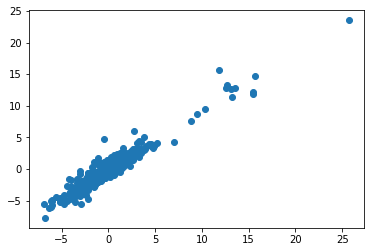

In [26]:
plt.plot(test_energies, test_predictions, 'o')
plt.show()

In [27]:
#forces = atomistic.predict_forces()

In [28]:
test_forces = [structure.arrays["forces"] for structure in test_structures]
test_forces = np.concatenate(test_forces, axis = 0) * FORCE_FACTOR

coef_der_test, central_indices_test, derivative_indices_test = \
get_coef_ders(test_structures, HYPERS, all_species)
for key in coef_der_test.keys():
    coef_der_test[key] *= MAGIC_NUMBER

In [29]:
for key in test_coefficients_all.keys():
    test_coefficients_all[key].requires_grad = True
prediction_forces = atomistic.get_forces(coef_der_test, central_indices_test, derivative_indices_test, 
                                         test_coefficients_all,
                                         structural_indices = get_structural_indices(test_structures),
                                         central_species = get_central_species(test_structures))


tensor([ 9.0668e-01,  1.9149e-01,  3.9534e-02, -7.4733e-03,  9.4849e-05,
        -5.1738e-06,  3.3760e-08, -4.6566e-10,  5.5879e-09,  3.7253e-09,
        -6.5732e-02,  5.2424e-02, -7.6401e-03, -1.5376e-02, -7.9785e-03,
        -2.9125e-02,  4.1247e-03,  1.0100e-02,  4.1273e-02,  4.7320e-02],
       grad_fn=<SliceBackward>)
torch.Size([500, 70])


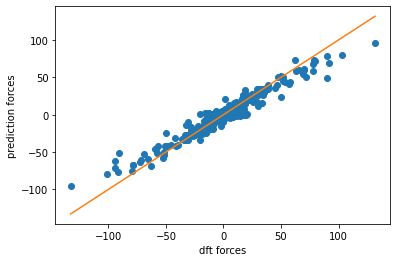

In [30]:
plt.plot(test_forces.reshape([-1]), prediction_forces.data.cpu().numpy().reshape([-1]), 'o')
min_f = np.min(test_forces)
max_f = np.max(test_forces)
plt.plot([min_f, max_f], [min_f, max_f])
plt.xlabel("dft forces")
plt.ylabel("prediction forces")
plt.savefig("ready.pdf", bbox_inches = 'tight')
plt.show()